In [8]:
from joblib import Parallel, delayed
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from utils import *
from tqdm import tqdm
import seaborn as sns

In [9]:
files = list(glob.glob('gecco/*fg_all_norm.*'))
print(files)

['gecco/m_DummyRegressor__rp_18__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_13__fg_all_norm.parquet', 'gecco/m_RandomForestRegressor__rp_6__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_8__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_12__fg_all_norm.parquet', 'gecco/m_RandomForestRegressor__rp_19__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_1__fg_all_norm.parquet', 'gecco/m_RandomForestRegressor__rp_21__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_15__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_7__fg_all_norm.parquet', 'gecco/m_RandomForestRegressor__rp_14__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_5__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_24__fg_all_norm.parquet', 'gecco/m_RandomForestRegressor__rp_22__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_22__fg_all_norm.parquet', 'gecco/m_RandomForestRegressor__rp_9__fg_all_norm.parquet', 'gecco/m_DummyRegressor__rp_16__fg_all_norm.parquet', 'gecco/m_RandomForestRegressor__rp_7__fg_all_

In [10]:
generalization_dict = {}
for file in tqdm(files):
    df = pd.read_parquet(path=file)
    meta_model = df.metamodel.unique()[0]
    problem_out = df.removed_function.unique()[0]
    feature_group = df.feature_group.unique()[0]
    vd = df.groupby('alpha').mean(numeric_only=True).reset_index().sort_values('alpha')
    generalization_dict[(meta_model, problem_out, feature_group)] = (list(vd.alpha), list(vd.pairwise_error))

100%|██████████| 48/48 [05:01<00:00,  6.28s/it]


In [11]:
errors = {}
feature_groups = list(np.unique([x[2] for x in list(generalization_dict.keys())]))
meta_models = list(np.unique([x[0] for x in list(generalization_dict.keys())]))


meta_model = 'RandomForestRegressor'
for feature_group in feature_groups:
    subset = [x for x in list(generalization_dict.keys()) if x[2]==feature_group and x[0]==meta_model]
    alphas = np.array([generalization_dict[x][0] for x in subset]).mean(axis=0)
    pw_errors = np.array([generalization_dict[x][1] for x in subset]).mean(axis=0)
    errors[str(feature_group)] = (alphas, pw_errors)
    
meta_model = 'DummyRegressor'
feature_group = 'all'
subset = [x for x in list(generalization_dict.keys()) if x[2]==feature_group and x[0]==meta_model]
alphas = np.array([generalization_dict[x][0] for x in subset]).mean(axis=0)
pw_errors = np.array([generalization_dict[x][1] for x in subset]).mean(axis=0)
errors['dummy'] = (alphas, pw_errors)

/tmp/ipykernel_250047/1660517248.py:16: RuntimeWarning: Mean of empty slice.
  alphas = np.array([generalization_dict[x][0] for x in subset]).mean(axis=0)
/opt/conda/envs/Base/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_250047/1660517248.py:17: RuntimeWarning: Mean of empty slice.
  pw_errors = np.array([generalization_dict[x][1] for x in subset]).mean(axis=0)


In [12]:
feature_groups

['all_norm']

In [13]:
generalization_dict

{('DummyRegressor',
  18,
  'all_norm'): ([0.0,
   0.1,
   0.2,
   0.3,
   0.4,
   0.5,
   0.6000000000000001,
   0.7000000000000001,
   0.8,
   0.9,
   1.0], [0.07804347826086956,
   0.08304347826086957,
   0.09543478260869566,
   0.11543478260869565,
   0.13978260869565218,
   0.1776086956521739,
   0.2258695652173913,
   0.2593478260869565,
   0.29978260869565215,
   0.325,
   0.32956521739130434]),
 ('DummyRegressor',
  13,
  'all_norm'): ([0.0,
   0.1,
   0.2,
   0.3,
   0.4,
   0.5,
   0.6000000000000001,
   0.7000000000000001,
   0.8,
   0.9,
   1.0], [0.12304347826086956,
   0.09934782608695653,
   0.10543478260869565,
   0.13478260869565217,
   0.16304347826086957,
   0.19847826086956522,
   0.21782608695652175,
   0.25369565217391304,
   0.2843478260869565,
   0.3176086956521739,
   0.3269565217391304]),
 ('RandomForestRegressor',
  6,
  'all_norm'): ([0.0,
   0.1,
   0.2,
   0.3,
   0.4,
   0.5,
   0.6000000000000001,
   0.7000000000000001,
   0.8,
   0.9,
   1.0], [0.311173

In [14]:
t=pd.DataFrame({k:v[1] for k,v in generalization_dict.items()}).T

In [15]:
t.index.names=['model','problem','features']
t.columns=[round(x,1) for x in np.arange(0,1.1,0.1)]

In [16]:
tt=t.reset_index()

In [17]:
ttt=tt.melt(['problem','features','model'], var_name='alpha', value_name='error').sort_values('features')

In [18]:
ttt['is_normalized']=ttt['features'].apply(lambda x:x.startswith('norm_'))

In [19]:
ttt['feature_name']=ttt['features'].apply(lambda x:x.replace('norm_',''))

<Figure size 640x480 with 0 Axes>

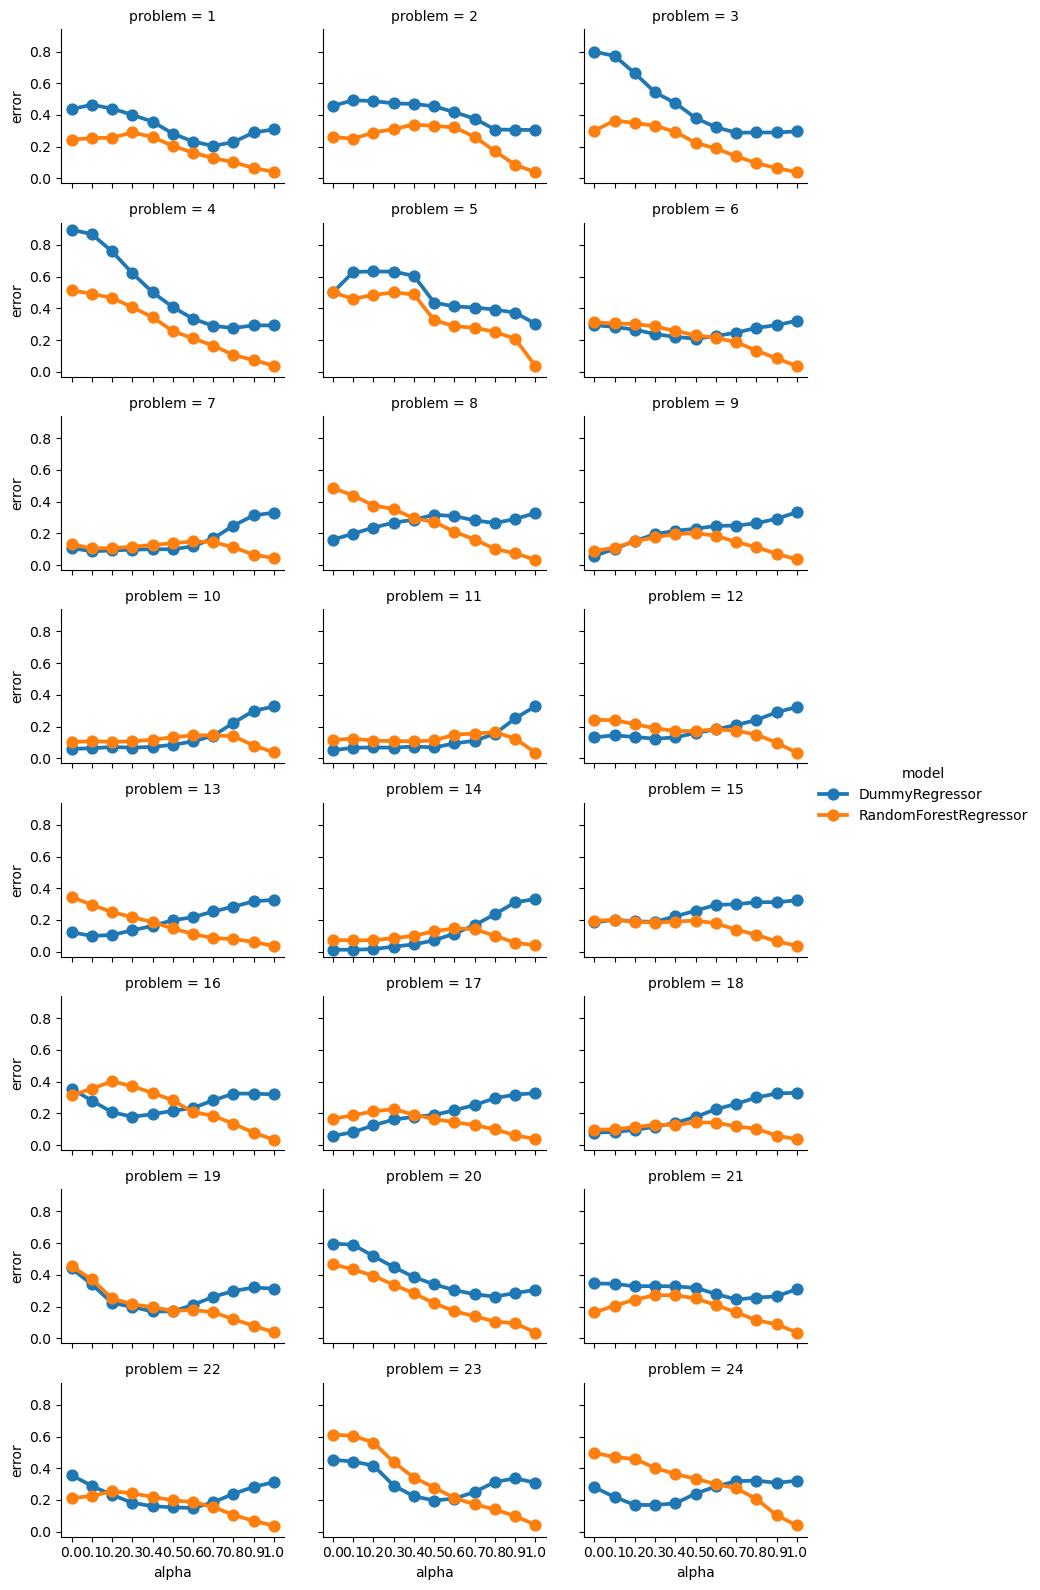

In [20]:
plt.figure()
ax=sns.catplot(ttt.query('features=="all_norm"'), hue='model',x='alpha',y='error', col='problem', kind='point', col_wrap=3,height=2,aspect=1.4)

plt.savefig(f'figures/error_per_problem.pdf', bbox_inches='tight', pad_inches=0)


In [ ]:
ela = load_ela()
features = [x for x in ela.columns if '.' in x]
ela_mean=ela.groupby(['problem1','problem2','instance1','instance2','alpha','dim']).mean().drop(columns=['algorithm_run'])

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import distinctipy
import matplotlib.patches as mpatches
problem_colors =  distinctipy.get_colors(24)
def plot (ela_mean, plot_norm=False, scale=False):
    features_of_interest=[c for c in ela_mean.columns if (plot_norm and c.startswith('norm')) or (not plot_norm and not c.startswith('norm')) ]
    e=ela_mean[features_of_interest].replace([np.inf,-np.inf],np.nan).dropna(axis=1)
    if scale:
        e=pd.DataFrame(MinMaxScaler().fit_transform(e), index=e.index, columns=e.columns)
    ela_2d = TSNE(n_components=2).fit_transform(e)
    ela_2d=pd.DataFrame(ela_2d, index=ela_mean_no_norm.index, columns=['x','y'])
    
    fig, ax = plt.subplots(figsize=(20,20))
    for index, row in ela_2d.query('problem1!=problem2').sample(10000).reset_index().iterrows():
        draw_pie(row['x'],row['y'],100,row['alpha'], ax=ax, colors=[problem_colors[int(row['problem1'])-1], problem_colors[int(row['problem2'])-1]])

    colors = [mpatches.Circle((0.5, 0.5), 0.25, facecolor=color,
                        edgecolor=color, linewidth=3) for problem_index, color in enumerate(problem_colors)]

    ax.legend(colors,range(1,25))
    plt.tight_layout()
    plt.savefig(f'figures/ela_2d_norm_{plot_norm}.pdf', bbox_inches='tight', pad_inches=0)
    return e, ela_2d

In [ ]:
ela_mean_norm, ela_2d_norm = plot(ela_mean, plot_norm=True, scale=True)

In [ ]:
ela_mean_no_norm, ela_2d_no_norm = plot(ela_mean, plot_norm=False, scale=True)

In [ ]:
cos_sim=pd.DataFrame(cosine_similarity(ela_mean_no_norm,ela_mean_no_norm), index=ela_mean_no_norm.index, columns=ela_mean_no_norm.index)

In [ ]:
cos_sim_no_norm=cos_sim.copy()

In [ ]:
cos_sim

In [ ]:
for problem_id in range(1,25):
    print("PROBLEM ", problem_id)
    plt.figure()
    print(cos_sim.loc[(1,problem_id,1,1,0), (1,problem_id,1,1,1)])
    x=cos_sim.loc[(1,problem_id,1,1,0),(1,problem_id,1,1)].melt()
    sns.lineplot(x,x='alpha',y='value')
    plt.show()

In [ ]:
for alpha in cos_sim.reset_index()['alpha'].unique():
    print(alpha)
    plt.figure()
    h=cos_sim.query('alpha==@alpha and instance1<=3 and instance2<=3').droplevel([4,5], axis=0).droplevel([4,5], axis=1)
    print(h.shape)
    sns.heatmap(h)
    plt.show()

In [ ]:
# Import the modules for data processing and plotting
import numpy as np
import matplotlib.pyplot as plt

# Define a function that draws a pie marker at a given position with a given size and alpha
def draw_pie(x, y, size, alpha, ax=None, colors=None):
    # If no axis is given, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()
    # Define the colors for the two slices of the pie
    if colors is None:
        colors = ["red", "blue"]
    # Define the angles for the two slices of the pie based on the alpha parameter
    angles = [0, 2 * np.pi * alpha, 2 * np.pi]
    # Loop through the angles and draw the slices
    for i in range(len(angles) - 1):
        # Calculate the x and y coordinates of the slice
        x_coords = [0] + np.cos(np.linspace(angles[i], angles[i + 1], 10)).tolist() + [0]
        y_coords = [0] + np.sin(np.linspace(angles[i], angles[i + 1], 10)).tolist() + [0]
        # Combine the coordinates into a marker shape
        xy = np.column_stack([x_coords, y_coords])
        # Scatter the marker at the given position with the given size and color
        ax.scatter(x, y, marker=xy, s=size, facecolor=colors[i])
    # Return the axis
    return ax

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a function that generates 24 colors from the matplotlib color names
def generate_colors(color_count):
    # Get the list of matplotlib color names
    color_names = list(mcolors.CSS4_COLORS.keys())
    # Shuffle the list to get random colors
    np.random.shuffle(color_names)
    # Return the first 24 colors from the list
    return color_names[:color_count]

# Test the function and print the generated colors
problem_colors = generate_colors(24)